In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import seaborn as sns

### Label mapping

In [3]:
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


### Data loading

In [5]:
train_dir = r"D:\Project\PG Project\Data\Image Data\seg_train\seg_train"
test_dir = r"D:\Project\PG Project\Data\Image Data\seg_test\seg_test"

def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [6]:
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading D:\Project\PG Project\Data\Image Data\seg_train\seg_train


100%|██████████| 2381/2381 [00:01<00:00, 1504.63it/s]


Images file have been loaded
loading D:\Project\PG Project\Data\Image Data\seg_test\seg_test


100%|██████████| 501/501 [00:00<00:00, 1564.35it/s]


Images file have been loaded


In [7]:
print("train dataset size",len(train_images), len(train_labels))
print("test dataset size",len(test_images), len(test_labels))

train dataset size 13986 13986
test dataset size 2993 2993


### Normalisation

In [9]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

In [10]:
class EpochTimeLogger(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = (time.time() - self.epoch_start) * 1000  # ms
        self.epoch_times.append(duration)

### Model loading

In [12]:
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [13]:
VGG16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Top layers adding

In [15]:
x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

In [16]:
for layer in  VGG16_model.layers:
    layer.trainable = False

In [17]:
model_vgg = Model(inputs=VGG16_model.input, outputs=predictions)

model_vgg.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [18]:
print(train_labels.shape)
print(train_labels[:5])

(13986,)
[0 0 0 0 0]


In [19]:
train_labels = to_categorical(train_labels, num_classes=6)  # shape → (N, 6)
test_labels = to_categorical(test_labels, num_classes=6)

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

checkpointer = ModelCheckpoint(filepath='bestvalue_VGG.keras', verbose=0, save_best_only=True)

time_logger = EpochTimeLogger()

callback_list = [checkpointer, earlystopping, time_logger]

history_vgg = model_vgg.fit(
    train_images_norm, train_labels,
    validation_data=(test_images_norm, test_labels),
    batch_size=128,
    epochs=15,
    callbacks=callback_list
)


test_loss, test_acc = model_vgg.evaluate(test_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.2389 - loss: 1.8273 - val_accuracy: 0.6839 - val_loss: 1.3065
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 450s 4s/step - accuracy: 0.4972 - loss: 1.3292 - val_accuracy: 0.7551 - val_loss: 1.0048
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.6249 - loss: 1.0512 - val_accuracy: 0.7858 - val_loss: 0.8400
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 455s 4s/step - accuracy: 0.6925 - loss: 0.8968 - val_accuracy: 0.7962 - val_loss: 0.7402
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.7178 - loss: 0.8194 - val_accuracy: 0.8082 - val_loss: 0.6730
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.7351 - loss: 0.7495 - val_accuracy: 0.8132 - val_loss: 0.6241
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.7555 - loss: 0.7000 - val_accuracy: 0.8149 - val_loss: 0.5885
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 419s 4s/step - accuracy: 0.7711 - loss: 0.6555 - val_accu

### Model saving

In [21]:
model_vgg.save("VGG16_model.keras")

### Training time

In [23]:
for i, t in enumerate(time_logger.epoch_times):
    print(f"Epoch {i+1} duration: {t:.2f} ms")

Epoch 1 duration: 446143.41 ms
Epoch 2 duration: 449971.99 ms
Epoch 3 duration: 445416.15 ms
Epoch 4 duration: 454586.00 ms
Epoch 5 duration: 458603.68 ms
Epoch 6 duration: 416688.02 ms
Epoch 7 duration: 446299.93 ms
Epoch 8 duration: 418820.13 ms
Epoch 9 duration: 419721.07 ms
Epoch 10 duration: 416088.44 ms
Epoch 11 duration: 427737.31 ms
Epoch 12 duration: 434960.37 ms
Epoch 13 duration: 438344.72 ms
Epoch 14 duration: 431413.96 ms
Epoch 15 duration: 432407.03 ms


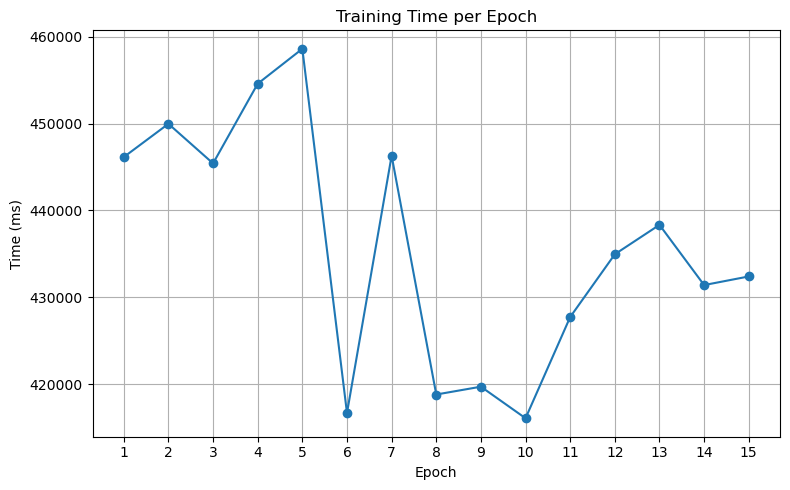

In [24]:
epoch_times = time_logger.epoch_times
epoch_numbers = np.arange(1, len(epoch_times) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epoch_numbers, epoch_times, marker='o')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (ms)")
plt.grid(True)
plt.xticks(epoch_numbers)
plt.tight_layout()
plt.show()

### Model accuracy

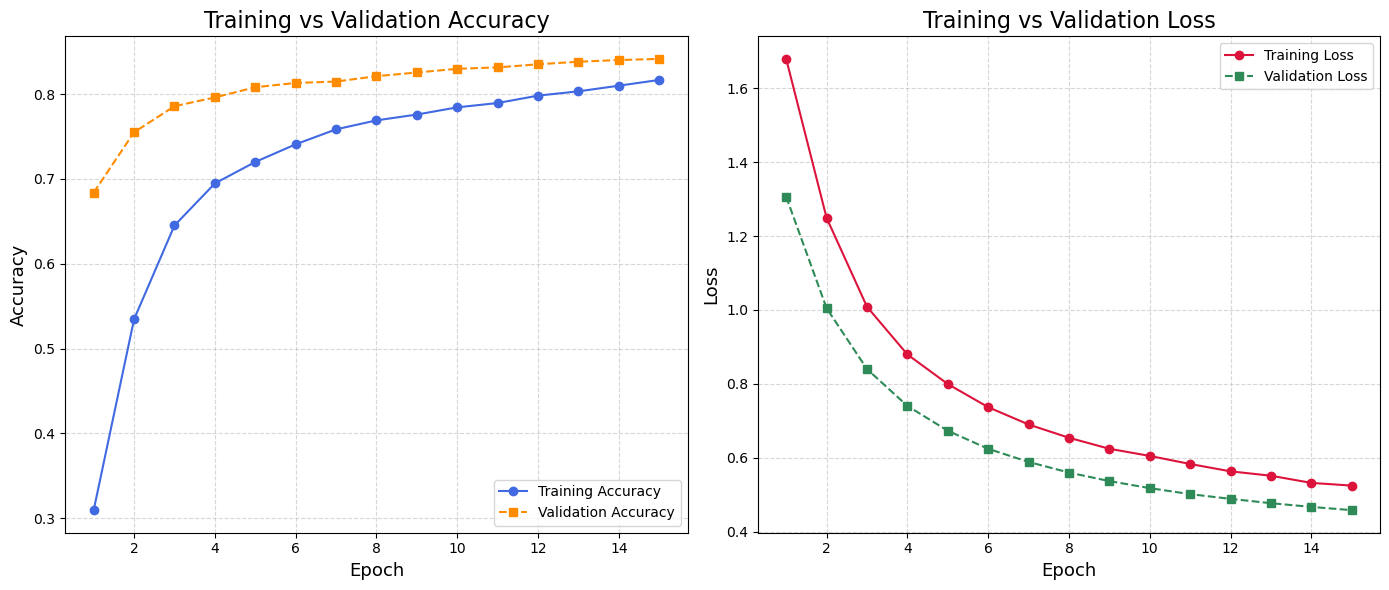

In [29]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(14,6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, marker='o', linestyle='-', color='royalblue', label='Training Accuracy')
    plt.plot(epochs, val_acc, marker='s', linestyle='--', color='darkorange', label='Validation Accuracy')
    plt.title("Training vs Validation Accuracy", fontsize=16)
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, marker='o', linestyle='-', color='crimson', label='Training Loss')
    plt.plot(epochs, val_loss, marker='s', linestyle='--', color='seagreen', label='Validation Loss')
    plt.title("Training vs Validation Loss", fontsize=16)
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Loss', fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_loss_accuracy(history_vgg)

### Confusion matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 997ms/step


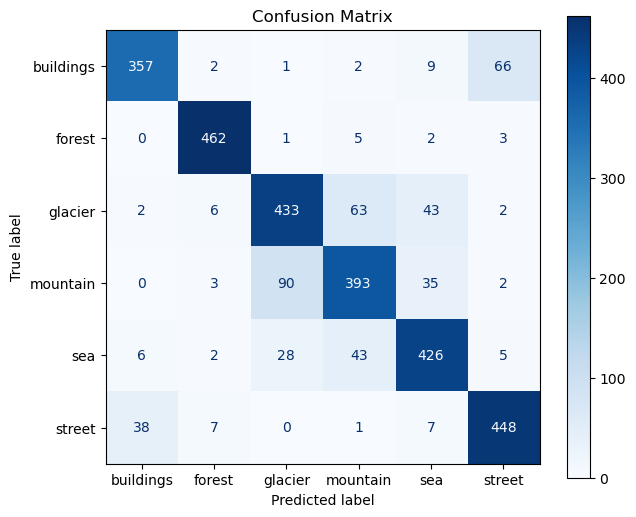

In [31]:
predicted_probs = model_vgg.predict(test_images_norm)
predicted_labels = np.argmax(predicted_probs, axis=1)

true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### Precision Recall F1-score

In [33]:
report = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

   buildings     0.8859    0.8169    0.8500       437
      forest     0.9585    0.9767    0.9675       473
     glacier     0.7830    0.7887    0.7858       549
    mountain     0.7751    0.7514    0.7631       523
         sea     0.8161    0.8353    0.8256       510
      street     0.8517    0.8942    0.8724       501

    accuracy                         0.8416      2993
   macro avg     0.8451    0.8439    0.8441      2993
weighted avg     0.8415    0.8416    0.8412      2993



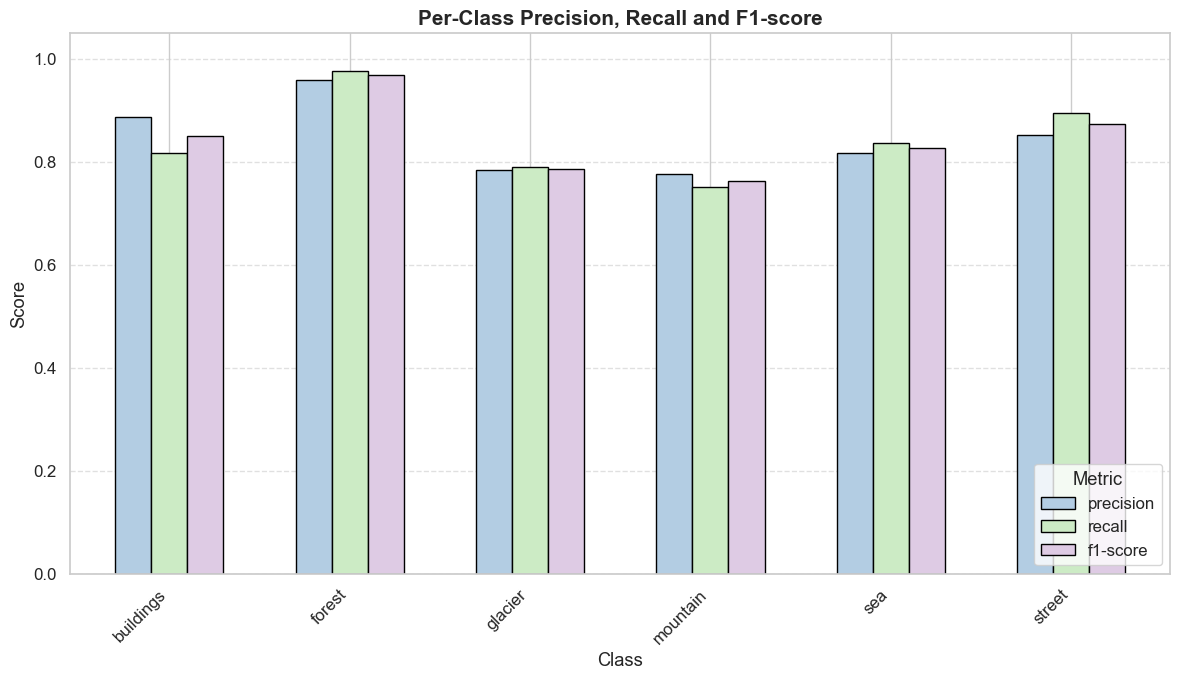

In [39]:
df = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(df).transpose().iloc[:-3][['precision', 'recall', 'f1-score']]

sns.set(style="whitegrid", font_scale=1.1)
soft_colors = sns.color_palette("Pastel1")[1:4]

ax = df_report.plot(kind='bar', figsize=(12, 7), width=0.6, color=soft_colors, edgecolor='black')

plt.title('Per-Class Precision, Recall and F1-score', fontsize=15, weight='bold')
plt.ylabel('Score')
plt.xlabel('Class')
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Misclassified examples

94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 999ms/step


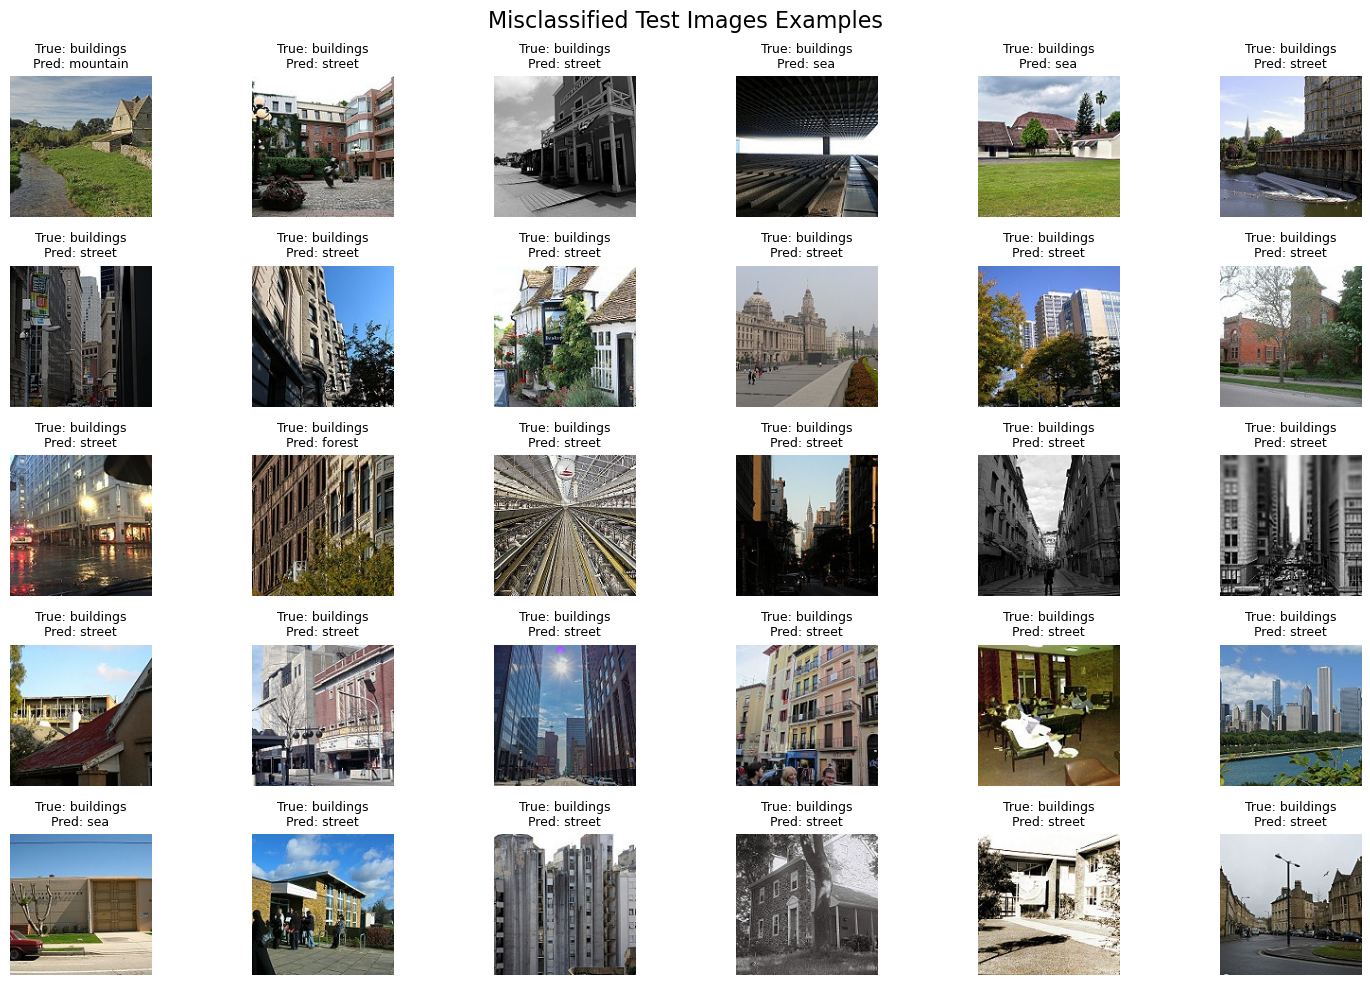

In [51]:
predicted_labels = np.argmax(model_vgg.predict(test_images_norm), axis=1)

true_labels = np.argmax(test_labels, axis=1)

misclassified_idx = np.where(predicted_labels != true_labels)[0]

misclassified_idx = misclassified_idx[:30]

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx):
    plt.subplot(5, 6, i+1)
    img = test_images[idx]
    img = (img).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    true = class_names[true_labels[idx]]
    pred = class_names[predicted_labels[idx]]
    plt.title(f"True: {true}\nPred: {pred}", fontsize=9)

plt.suptitle("Misclassified Test Images Examples", fontsize=16)
plt.tight_layout()
plt.show()

### Predictions on Unlabeled Images

In [43]:
VGG16_loaded_model = load_model("VGG16_model.keras")

In [45]:
pred_dir=r"D:\Project\PG Project\Data\Image Data\seg_pred\seg_pred"

def load_pred_images(pred_dir, image_size=(150, 150), max_images=None):
    images = []

    for file in sorted(os.listdir(pred_dir)):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(pred_dir, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            images.append(image)
            if max_images and len(images) >= max_images:
                break

    return np.array(images, dtype='float32')

In [47]:
pred_images = load_pred_images(pred_dir, image_size=IMAGE_SIZE)

In [51]:
pred_images_norm = pred_images / 255.0
pred_probs = VGG16_loaded_model.predict(pred_images_norm)
pred_classes = np.argmax(pred_probs, axis=1)

228/228 ━━━━━━━━━━━━━━━━━━━━ 203s 886ms/step


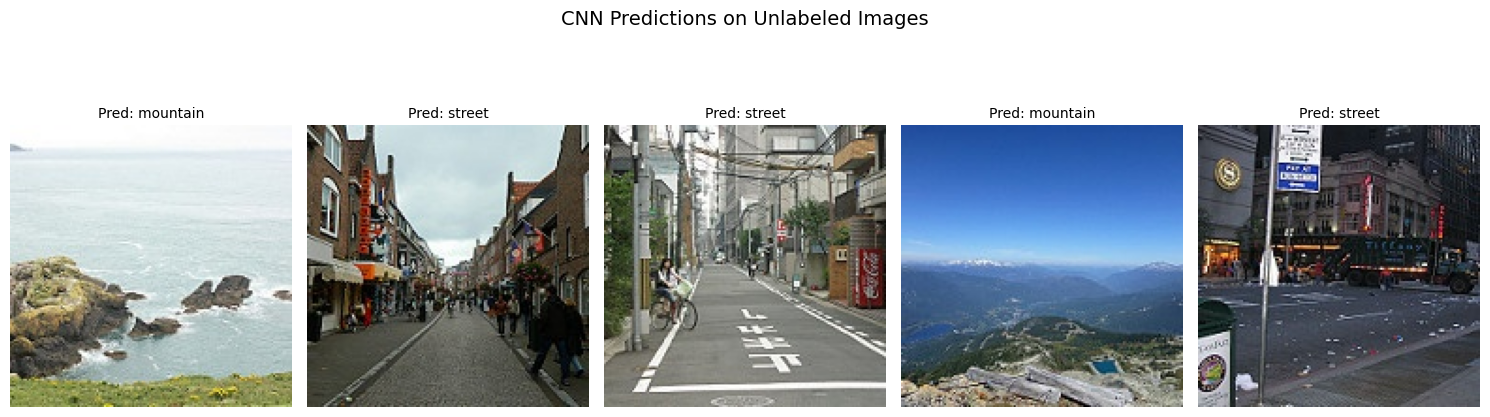

In [52]:
np.random.seed(40)
sample_idxs = np.random.choice(len(pred_images), 5, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_idxs):
    img = pred_images[idx]
    img = (img).astype('uint8')
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_classes[idx]]}", fontsize=10)

plt.suptitle("CNN Predictions on Unlabeled Images", fontsize=14)
plt.tight_layout()
plt.show()